In [1]:
import os
import sys

from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np
import pandas as pd
import torch

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

---

In [84]:
target = 'fnta'

In [85]:
from Bio import SeqIO

def get_sequence_from_pdb(target_path):
    warnings.filterwarnings('ignore')
    recs = list(SeqIO.parse(target_path, "pdb-atom"))
    return recs[0]

seq = str(get_sequence_from_pdb(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{target}/receptor.pdb').seq)

In [86]:
seq

'SLDXXXXXXXXXXXXXXXXXXVPQNDGPNPVVQIIYSDKFRDVYDXFRXXLXXXXXXXXXFXLTRDAIELNAANYTVWXFRRVLLXXXXXXXXXEMNYITAIIQEQPKNYQVWXXRRVLVEWXRXPXQELEFIADILNQDAKNYXAWQHRQWVIQEFXXWXXEXXYVXQLLKEDVRNNSVWNQRYFVISNXXXYXXXXXXXXXXXXXXXXXXXVXXNESAWNYXKGIXQDXXXXXXXXXXXXXXXXXXXXXXXYXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXDTIRKEYWXYXXXXXXXXXXXXXXXXXXXLYSLXXXXAXERLQDXXVETVTSIEQAKVEEKIQEVFSSYXXXXXXXXLVLQREKXFXYLKRGLRQLTDAYECLDASRPWLCYWILHSLELLDEPIPQIVATDVCQFLELCQSPEGGFGGGPGQYPXLAPTYAAVNALCIIGTEEAYDIINREKLLQYLYSLKQPDGSFLMXVGGEVDVRSAYCAASVASLTNIITPDLFEGTAEWIARCQNWEGGIGGVPGMEAXGGYTFCGLAALVILKRERSLNLKSLLQWVTSRQMRFEGGFQGRCNKLVDGCYSFWQAGLLPLLXRALXAQXXXXLXXXXWMFXQQALQEYILMCCQCPAGGLLDKPGKSRDFYXTCYCLSGLSIAQHFGSGXXLXDVVLXXXENALQPTXPVYNIGPDKVIQATTYFLQKPVPGF'

In [88]:
actives = Chem.SDMolSupplier(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{target}/actives_final.sdf')
decoys = Chem.SDMolSupplier(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{target}/decoys_final.sdf')

In [97]:
# Load model
from src.architectures import SimpleCoembedding, SimpleCosine
from src.featurizers import MorganFeaturizer, ProtBertFeaturizer
mol_f = MorganFeaturizer()
prot_f = ProtBertFeaturizer()
model = SimpleCoembedding(
    mol_f.shape,
    prot_f.shape,
    latent_dimension=1024,
    latent_distance="Cosine",
    classify=True,
)
# model = torch.load("../best_models/dti_dg_morganM_protbertP_bm_best_model.sav").cuda()
model.load_state_dict(torch.load("../best_models/bindingdb_morgan_protbert_best_model.pt"))
# model = torch.load("../best_models/new_api/testBIOSNAP_best_model.sav")

FileNotFoundError: [Errno 2] No such file or directory: '../best_models/bindingdb_morgan_protbert_best_model.pt'

In [93]:
active_projections = []
decoy_projections = []

with torch.set_grad_enabled(False):
    for m in tqdm(actives):
        m_emb = mol_f(Chem.MolToSmiles(m)).cuda()
        m_proj = model.mol_projector(m_emb).detach().cpu().numpy()
        active_projections.append(m_proj)
    for m in tqdm(decoys):
        try:
            m_emb = mol_f(Chem.MolToSmiles(m)).cuda()
            m_proj = model.mol_projector(m_emb).detach().cpu().numpy()
            decoy_projections.append(m_proj)
        except Exception as e:
            continue
    seq_proj = model.prot_projector(prot_f(str(seq)).cuda()).cpu().numpy()

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/36647 [00:00<?, ?it/s]

In [94]:
from sklearn.manifold import TSNE
all_projections = np.concatenate([active_projections,decoy_projections,[seq_proj]],axis=0)
project_tsne = TSNE(metric="cosine").fit_transform(all_projections)

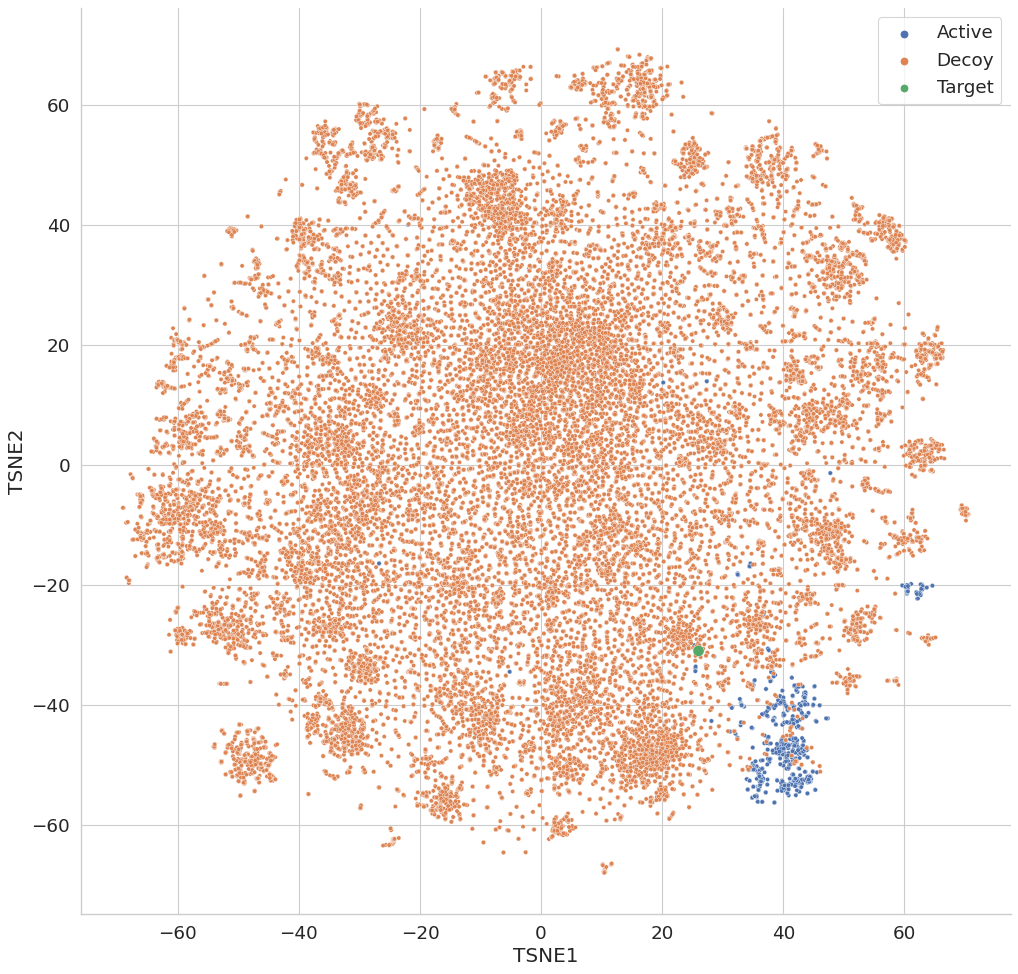

In [95]:
hue = ['Active']*len(active_projections)+['Decoy']*len(decoy_projections)+['Target']
size = [15]*len(active_projections)+[15]*len(decoy_projections)+[100]
plt.figure(figsize=(15, 15), dpi=80)
sns.scatterplot(x=project_tsne[:,0],
                y=project_tsne[:,1],
                hue=hue,
                s=size
               )
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
sns.despine()
plt.show()

In [38]:
from torch.nn import CosineSimilarity
from scipy.spatial.distance import cosine
cosine_sim = CosineSimilarity(dim=0)

In [39]:
from torch.nn import CosineSimilarity
from scipy.spatial.distance import cosine
cosine_sim = CosineSimilarity(dim=0)

active_scores = []
decoy_scores = []

pProj = torch.from_numpy(seq_proj).cuda()

with torch.set_grad_enabled(False):
    for mProj in tqdm(active_projections):
        affin = cosine_sim(pProj,torch.from_numpy(mProj).cuda()).cpu().numpy()
        active_scores.append(float(affin))
    for mProj in tqdm(decoy_projections):
        affin = cosine_sim(pProj,torch.from_numpy(mProj).cuda()).cpu().numpy()
        decoy_scores.append(float(affin))

  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/15958 [00:00<?, ?it/s]

In [40]:
df = pd.DataFrame({"scores":active_scores + decoy_scores,"label":(['active']*len(active_scores))+(['decoy']*len(decoy_scores))})

In [41]:
df

,scores,label
0,0.331547,active
1,0.250043,active
2,0.331547,active
3,0.250043,active
4,0.559042,active
...,...,...
16411,0.500771,decoy
16412,0.353025,decoy
16413,0.182055,decoy
16414,0.220934,decoy


In [42]:
import scipy
stat, pvalue = scipy.stats.ttest_ind(df[df['label'] == 'active']['scores'], df[df['label'] == 'decoy']['scores'],alternative='greater')
(stat, pvalue)

(28.28639282850245, 3.289785957350113e-172)

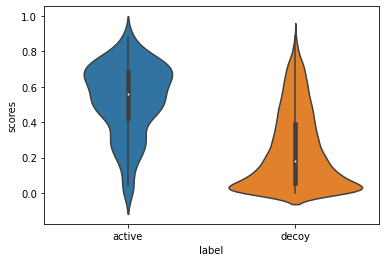

In [43]:
sns.violinplot(data=df, x='label', y='scores')
plt.show()

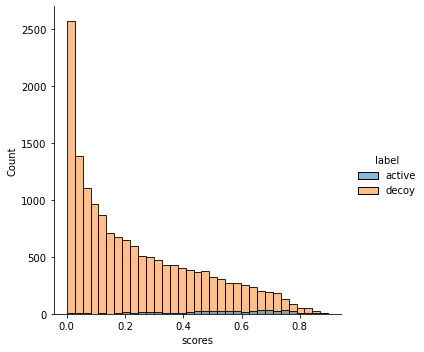

In [44]:
sns.displot(data=df,x='scores',hue='label')
plt.show()

---

# Process and clean all targets

In [97]:
from rdkit.Chem import PandasTools
import os
import glob
from pathlib import Path
from Bio import SeqIO

In [98]:
targets = [Path(i).name for i in glob.glob('/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/*') if os.path.isdir(i)]

In [122]:
target_pdb_map = pd.read_csv('/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/target_pdb_mapping.csv',header=None)
target_pdb_seq = {r.id.split('_')[0]: str(r.seq) for r in SeqIO.parse('/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/target_pdb_seqs.fasta','fasta')}
target_key_seq = {}
for _,r in target_pdb_map.iterrows():
    if r[1].upper() in target_pdb_seq.keys():
        target_key_seq[r[0]] = target_pdb_seq[r[1].upper()]
with open('/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/target_key_seqs.fasta','w+') as f:
    for k,v in target_key_seq.items():
        f.write(f">{k}\n{v}\n")
target_key_seq = SeqIO.to_dict(SeqIO.parse('/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/target_key_seqs.fasta','fasta'))
assert set(targets).difference(set(target_key_seq.keys())) == set()

In [127]:
str(target_key_seq[tid].seq)

'YNVFPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLNFTRLHDGIADIMISFGIKEHGDFYPFDGPSGLLAHAFPPGPNYGGDAHFDDDETWTSSSKGYNLFLVAAHEFGHSLGLDHSKDPGALMFPIYTYTGKSHFMLPDDDVQGIQSLYGPGDE'

In [128]:
active_dfs = {}
decoy_dfs = {}
link_dfs = {}

for tid in tqdm(targets):
    tseq = str(target_key_seq[tid].seq)
    actives_frame = PandasTools.LoadSDF(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{tid}/actives_final.sdf',
                                        smilesName='SMILES',molColName=None,includeFingerprints=True).drop_duplicates()
    decoys_frame = PandasTools.LoadSDF(f'/afs/csail.mit.edu/u/s/samsl/Work/databases/DUDe/{tid}/decoys_final.sdf',
                                        smilesName='SMILES',molColName=None,includeFingerprints=True).drop_duplicates()

    links = []
    for _, row in actives_frame.iterrows():
        links.append((tid, tseq, row.ID, row.SMILES, 1))
    for _, row in decoys_frame.iterrows():
        links.append((tid, tseq, row.ID, row.SMILES, 0))
    df = pd.DataFrame(links)
    
    active_dfs[tid] = actives_frame
    decoy_dfs[tid] = decoys_frame
    link_dfs[tid] = df

  0%|          | 0/102 [00:00<?, ?it/s]

[14:52:40] Explicit valence for atom # 7 N, 5, is greater than permitted
[14:52:40] ERROR: Could not sanitize molecule ending on line 3875828
[14:52:40] ERROR: Explicit valence for atom # 7 N, 5, is greater than permitted
[14:54:22] Explicit valence for atom # 7 N, 5, is greater than permitted
[14:54:22] ERROR: Could not sanitize molecule ending on line 586033
[14:54:22] ERROR: Explicit valence for atom # 7 N, 5, is greater than permitted
[14:55:03] Explicit valence for atom # 7 N, 5, is greater than permitted
[14:55:03] ERROR: Could not sanitize molecule ending on line 1169873
[14:55:03] ERROR: Explicit valence for atom # 7 N, 5, is greater than permitted
[14:55:18] Explicit valence for atom # 9 N, 5, is greater than permitted
[14:55:18] ERROR: Could not sanitize molecule ending on line 1034433
[14:55:18] ERROR: Explicit valence for atom # 9 N, 5, is greater than permitted


In [129]:
full_links = pd.concat(link_dfs.values()).reset_index(drop=True)
full_links.columns = ['Target_ID','Target_Seq','Molecule_ID','Molecule_SMILES','Label']

In [131]:
full_links

,Target_ID,Target_Seq,Molecule_ID,Molecule_SMILES,Label
0,cxcr4,DYKDDDDAGAPEGISIYTSDNYTEEMGSGDYDSMKEPCFREENANF...,CHEMBL1089844,[NH3+]C/C=C\CN(Cc1nc2ccccc2[nH]1)[C@@H]1CCCc2c...,1
1,cxcr4,DYKDDDDAGAPEGISIYTSDNYTEEMGSGDYDSMKEPCFREENANF...,CHEMBL1089844,[NH3+]C/C=C\CN(Cc1nc2ccccc2[nH]1)[C@@H]1CCCc2c...,1
2,cxcr4,DYKDDDDAGAPEGISIYTSDNYTEEMGSGDYDSMKEPCFREENANF...,CHEMBL1089844,[NH3+]C/C=C\CN(Cc1nc2ccccc2[nH]1)[C@H]1CCCc2cc...,1
3,cxcr4,DYKDDDDAGAPEGISIYTSDNYTEEMGSGDYDSMKEPCFREENANF...,CHEMBL1089844,[NH3+]C/C=C\CN(Cc1nc2ccccc2[nH]1)[C@H]1CCCc2cc...,1
4,cxcr4,DYKDDDDAGAPEGISIYTSDNYTEEMGSGDYDSMKEPCFREENANF...,CHEMBL1089845,[NH3+]C/C=C/CN(Cc1nc2ccccc2[nH]1)[C@@H]1CCCc2c...,1
...,...,...,...,...,...
1452562,mmp13,YNVFPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVT...,ZINC63372157,C[C@H](NC(=O)[C@H](CC1=c2ccccc2=[NH+]C1)N1C(=O...,0
1452563,mmp13,YNVFPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVT...,ZINC63373267,C[C@@H](NC(=O)[C@H](CC1=c2ccccc2=[NH+]C1)N1C(=...,0
1452564,mmp13,YNVFPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVT...,ZINC63373939,O=C(CCN1C(=O)N=C2C=CC=C[C@H]2C1=O)N[C@@H](CC1=...,0
1452565,mmp13,YNVFPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVT...,ZINC63374952,COc1ccc2c(c1)=C1CCN3C(=O)N([C@@H](C)C(=O)N[C@@...,0


In [132]:
full_links.to_csv('../dataset/DUDe/full.tsv',sep='\t',index=False)
for tid in tqdm(targets):
    active_dfs[tid].to_csv(f'../dataset/DUDe/{tid}_actives.tsv', sep='\t',index=False,header=None)
    decoy_dfs[tid].to_csv(f'../dataset/DUDe/{tid}_decoys.tsv', sep='\t',index=False,header=None)

  0%|          | 0/102 [00:00<?, ?it/s]

---
# Create Splits

In [15]:
subset_list = pd.read_csv(f'{BASE_DIR}/dataset/DUDe/dude_subset_list.txt',header=None)

In [70]:
cross_type_0 = subset_list[subset_list[1].isin(['protease','nuclear'])][0].values
cross_type_1 = subset_list[subset_list[1].isin(['kinase','gpcr'])][0].values

In [71]:
cross_type_0, len(cross_type_0)

(array(['ace', 'ada17', 'bace1', 'casp3', 'dpp4', 'fa10', 'fa7', 'hivpr',
        'lkha4', 'mmp13', 'reni', 'thrb', 'try1', 'tryb1', 'urok', 'andr',
        'esr1', 'esr2', 'gcr', 'mcr', 'ppara', 'ppard', 'pparg', 'prgr',
        'rxra', 'thb'], dtype=object),
 26)

In [72]:
cross_type_1, len(cross_type_1)

(array(['abl1', 'akt1', 'akt2', 'braf', 'cdk2', 'csf1r', 'egfr', 'fak1',
        'fgfr1', 'igf1r', 'jak2', 'kit', 'kpcb', 'lck', 'mapk2', 'met',
        'mk01', 'mk10', 'mk14', 'mp2k1', 'plk1', 'rock1', 'src', 'tgfr1',
        'vgfr2', 'wee1', 'aa2ar', 'adrb1', 'adrb2', 'cxcr4', 'drd3'],
       dtype=object),
 31)

In [90]:
dude_cross_type = pd.DataFrame([np.concatenate([cross_type_0,cross_type_1]), ['train']*len(cross_type_0) + ['test']*len(cross_type_1)]).T
dude_cross_type.to_csv(f'{BASE_DIR}/nbdata/dude_cross_type_train_test_split.csv',header=None,index=False)

In [73]:
from numpy.random import default_rng
seed = 61998

def random_split_list(x):
    rng = default_rng(seed)
    l = len(x)
    x_shuf = rng.permutation(x)
    x_0 = x_shuf[:l//2]
    x_1 = x_shuf[l//2:]
    return x_0, x_1

In [74]:
within_type = {}
for ty in ['protease','nuclear','kinase','gpcr']:
    within_0, within_1 = random_split_list(subset_list[subset_list[1] == ty][0].values)
    within_type[ty] = (within_0, within_1)

In [75]:
within_type_0 = np.concatenate([x[0] for x in within_type.values()])
within_type_1 = np.concatenate([x[1] for x in within_type.values()])

In [92]:
len(within_type_0), len(within_type_1)

(27, 30)

In [94]:
dude_within_type = pd.DataFrame([np.concatenate([within_type_0,within_type_1]), ['train']*len(cross_type_0) + ['test']*len(cross_type_1)]).T
dude_within_type.to_csv(f'{BASE_DIR}/nbdata/dude_within_type_train_test_split.csv',header=None,index=False)

---

# Plot Results

In [6]:
fulldf = pd.read_csv('../dataset/DUDe/full.tsv',sep='\t')
splitdf = pd.read_csv('../dataset/DUDe/dude_within_type_train_test_split.csv',header=None)

In [7]:
fulldf = fulldf[fulldf['Target_ID'].isin(splitdf[0])]
traindf = fulldf[fulldf['Target_ID'].isin(splitdf[splitdf[1] == 'train'][0])]
testdf = fulldf[fulldf['Target_ID'].isin(splitdf[splitdf[1] == 'test'][0])]

In [8]:
len(traindf[traindf['Label'] == 1]), len(traindf[traindf['Label'] == 0])

(8996, 406208)

In [9]:
len(testdf[testdf['Label'] == 1]), len(testdf[testdf['Label'] == 0])

(11430, 521132)

In [10]:
fulldf

,Target_ID,Target_Seq,Molecule_ID,Molecule_SMILES,Label
0,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089844,[NH3+]C/C=C\CN(Cc1nc2ccccc2[nH]1)C1CCCc2cccnc21,1
1,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089844,[NH3+]C/C=C\CN(Cc1nc2ccccc2[nH]1)C1CCCc2ccc[nH...,1
2,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089845,[NH3+]C/C=C/CN(Cc1nc2ccccc2[nH]1)C1CCCc2cccnc21,1
3,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089845,[NH3+]C/C=C/CN(Cc1nc2ccccc2[nH]1)C1CCCc2ccc[nH...,1
4,cxcr4,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,CHEMBL1089846,[NH3+]CC#CCN(Cc1nc2ccccc2[nH]1)C1CCCc2cccnc21,1
...,...,...,...,...,...
1438330,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63372157,CC(NC(=O)C(CC1=c2ccccc2=[NH+]C1)N1C(=O)N=C2C=C...,0
1438331,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63373267,CC(NC(=O)C(CC1=c2ccccc2=[NH+]C1)N1C(=O)N=C2C=C...,0
1438332,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63373939,O=C(CCN1C(=O)N=C2C=CC=CC2C1=O)NC(CC1=c2ccccc2=...,0
1438333,mmp13,FPRTLKWSKMNLTYRIVNYTPDMTHSEVEKAFKKAFKVWSDVTPLN...,ZINC63374952,COc1ccc2c(c1)=C1CCN3C(=O)N(C(C)C(=O)NC(C)C(=O)...,0


In [11]:
uniq_target = fulldf['Target_ID'].unique()
print(len(uniq_target))

uniq_seq = fulldf['Target_Seq'].unique()
print(len(uniq_seq))

uniq_drug = fulldf['Molecule_ID'].unique()
print(len(uniq_drug))

uniq_smile = fulldf['Molecule_SMILES'].unique()
print(len(uniq_smile))

57
57
788572
689002


In [12]:
subset_list = pd.read_csv(f'{BASE_DIR}/dataset/DUDe/dude_subset_list.txt',header=None)

In [13]:
subset_types = subset_list[1].unique()

In [14]:
for st in subset_types:
    t_covg = []
    
    target_list = subset_list[subset_list[1] == st][0].values
    subsetdf = fulldf[fulldf['Target_ID'].isin(target_list)]
    
    for t in subsetdf['Target_ID'].unique():
        subdf = fulldf[fulldf['Target_ID'] == t]
        t_covg.append(len(subdf['Molecule_SMILES'].unique()))
        
    print(st, np.median(t_covg))

protease 17010.0
nuclear 14792.0
kinase 8747.5
gpcr 15542.0


In [15]:
for st in subset_types:
    d_covg = []
    
    target_list = subset_list[subset_list[1] == st][0].values
    subsetdf = fulldf[fulldf['Target_ID'].isin(target_list)]
    
    n_d = len(subsetdf['Molecule_ID'].unique())
    n_t = len(subsetdf['Target_ID'].unique())
    
    d_covg = subsetdf.groupby('Molecule_ID').count()['Target_ID']  
    t_covg = subsetdf.groupby('Target_ID').count()['Molecule_ID']
    
    print(f"Subset {st} ({n_d} drugs, {n_t} targets): Median Drug {np.median(d_covg)}, Target {np.median(t_covg)} coverage")

Subset protease (286089 drugs, 15 targets): Median Drug 1.0, Target 18563.0 coverage
Subset nuclear (151133 drugs, 11 targets): Median Drug 1.0, Target 15409.0 coverage
Subset kinase (315399 drugs, 26 targets): Median Drug 1.0, Target 9271.5 coverage
Subset gpcr (99671 drugs, 5 targets): Median Drug 1.0, Target 16257.0 coverage


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [17]:
no_contrast_dir = '../results/2022-09-28-noContrast/'
df_l = []
for i in glob(f'{no_contrast_dir}/*_scores.csv'):
    tg = i.split('_')[1]
    tdf = pd.read_csv(i,index_col=0)
    tdf['target'] = tg
    df_l.append(tdf)
no_contrast_df = pd.concat(df_l)

In [18]:
contrast_dir = '../results/2022-09-28-Contrast/'
df_l = []
for i in glob(f'{contrast_dir}/*_scores.csv'):
    tg = i.split('_')[1]
    tdf = pd.read_csv(i,index_col=0)
    tdf['target'] = tg
    df_l.append(tdf)
contrast_df = pd.concat(df_l)

In [19]:
import scipy

pval_dict = {}
for t in contrast_df.target.unique():
    t_df = contrast_df[contrast_df.target == t]
    t_active = t_df[t_df.label == 'active']
    t_decoy = t_df[t_df.label == 'decoy']
    t_stat, t_pval = scipy.stats.ttest_ind(t_active.scores, t_decoy.scores, alternative='greater')
    pval_dict[t] = (t_stat, t_pval)
    
pval_class_dict = {}

for st in subset_types:
    subset_list_test = subset_list[subset_list[0].isin(splitdf[splitdf[1] == 'test'][0])]
    t_type_list = subset_list_test[subset_list_test[1] == st][0]
    med_stat = np.median([pval_dict[t][0] for t in t_type_list])
    med_pval = np.median([pval_dict[t][1] for t in t_type_list])
    pval_class_dict[st] = (med_stat, med_pval)
    print(st, med_stat, med_pval)

protease 103.13067469327777 0.0
nuclear 120.82237321469039 0.0
kinase 87.23318724904003 0.0
gpcr 20.519803302952333 2.1691678055115054e-68


In [20]:
contrast_df

,scores,label,target
0,0.438841,active,drd3
1,0.554660,active,drd3
2,0.672034,active,drd3
3,0.432768,active,drd3
4,0.478631,active,drd3
...,...,...,...
20370,0.122491,decoy,ppara
20371,0.091499,decoy,ppara
20372,0.304530,decoy,ppara
20373,0.208292,decoy,ppara


In [21]:
# def cohen_d(x0,x1):
#     u0 = np.mean(x0)
#     u1 = np.mean(x1)
#     s = np.std(np.concatenate([x0,x1]))
#     return (u1 - u0) / s

def cohen_d(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u2 - u1) / s

In [22]:
effect_df = []
for tg in contrast_df['target'].unique():
    tg_df = contrast_df[contrast_df['target'] == tg]
    act_df = tg_df[tg_df['label'] == 'active']
    dec_df = tg_df[tg_df['label'] == 'decoy']
    cohd = cohen_d(dec_df['scores'], act_df['scores'])
    effect_df.append(('contrast', tg, cohd))
for tg in no_contrast_df['target'].unique():
    tg_df = no_contrast_df[no_contrast_df['target'] == tg]
    act_df = tg_df[tg_df['label'] == 'active']
    dec_df = tg_df[tg_df['label'] == 'decoy']
    cohd = cohen_d(dec_df['scores'], act_df['scores'])
    effect_df.append(('no contrast', tg, cohd))
effect_df = pd.DataFrame(effect_df,columns=['Model','Target','Effect Size']).pivot('Target','Model')
effect_df.columns = ['Contrast','No Contrast']

In [24]:
effect_df.median()

Contrast       4.71617
No Contrast    0.72970
dtype: float64

In [181]:
def distance_from_line(x0,y0):
    x1,y1 = (-1,-1)
    x2,y2 = (10,10)
    
    d = np.abs((x2-x1)*(y1-y0) - (x1 - x0)*(y2 - y1)) / np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return d

In [217]:
len(splitdf[splitdf[1]=='test'])

31

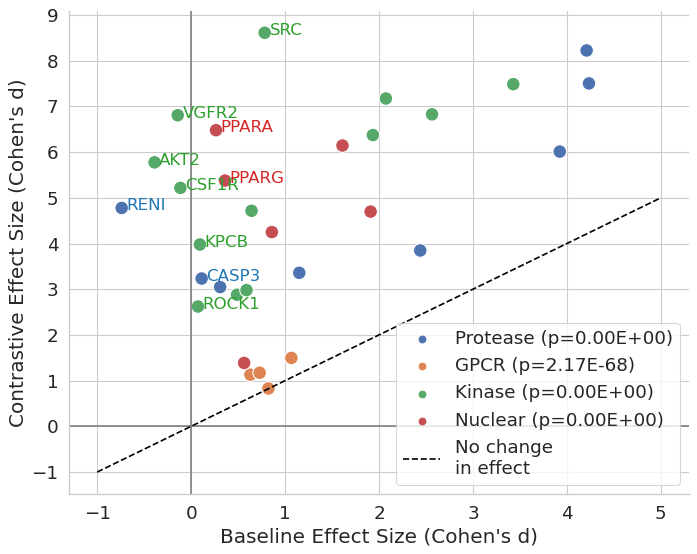

In [186]:
plt.figure(figsize=(10, 8), dpi=80)
sns.set(style="whitegrid", font_scale=1.5)
target_type_hue = subset_list[subset_list[0].isin(splitdf[splitdf[1] == 'test'][0])].sort_values(by=0)[1].map({
    'protease': f'Protease (p={pval_class_dict["protease"][1]:.2E})',
    'gpcr': f'GPCR (p={pval_class_dict["gpcr"][1]:.2E})',
    'kinase': f'Kinase (p={pval_class_dict["kinase"][1]:.2E})',
    'nuclear': f'Nuclear (p={pval_class_dict["nuclear"][1]:.2E})'
}).values

pal_map = {
    f'Protease (p={pval_class_dict["protease"][1]:.2E})': sns.color_palette('tab10')[0],
    f'GPCR (p={pval_class_dict["gpcr"][1]:.2E})': sns.color_palette('tab10')[1],
    f'Kinase (p={pval_class_dict["kinase"][1]:.2E})': sns.color_palette('tab10')[2],
    f'Nuclear (p={pval_class_dict["nuclear"][1]:.2E})': sns.color_palette('tab10')[3]
}

sns.scatterplot(
    data=effect_df,
    x='No Contrast',
    y='Contrast',
    hue = target_type_hue,
    s = 150
)

residuals = {}
for i, r in effect_df.reset_index().iterrows():
    xef = r['No Contrast']
    yef = r['Contrast']
    # if (xef > 2) or (yef > 6) or (yef-xef < 0):
    residuals[r['Target']] = distance_from_line(xef, yef)
    if (yef / xef > 10) or (yef/xef < 1):
        plt.annotate(r['Target'].upper(),
                     (xef+0.05, yef-0.05),
                     color = pal_map[target_type_hue[i]],
                     fontsize='small',
                     # backgroundcolor='white'
                    )
plt.xlabel("Baseline Effect Size (Cohen's d)")
plt.ylabel("Contrastive Effect Size (Cohen's d)")
plt.xticks(np.arange(-1,10,1))
plt.yticks(np.arange(-1,10,1))
plt.axvline(0,linestyle="-",color="grey")
plt.axhline(0,linestyle="-",color="grey")
plt.plot([-1,5],[-1,5],linestyle="--",color="black",label='No change\nin effect')
plt.legend(loc='lower right')
sns.despine()
plt.savefig("../img/dude_effect_size_scatterplot.png",bbox_inches="tight")
plt.savefig("../img/dude_effect_size_scatterplot.svg",bbox_inches="tight")
plt.show()

In [208]:
pd.merge(pd.DataFrame({'Target':residuals.keys(), 'Residual':residuals.values()}),subset_list, left_on='Target', right_on=0).sort_values(by='Residual', ascending=False).drop([0],axis=1).head()

,Target,Residual,1
25,src,5.535361,kinase
29,vgfr2,4.913750,kinase
19,ppara,4.394394,nuclear
3,akt2,4.358704,kinase
22,reni,3.901444,protease


In [189]:
no_contrast = pd.read_csv('../results/2022-09-28-noContrast/all_results.csv')
contrast = pd.read_csv('../results/2022-09-28-Contrast/all_results.csv')

In [190]:
no_contrast[no_contrast['Subset'] == 'protease']

,Target,Model,TStat,PVal,Subset
23,ada17,testBIOSNAP-noContrast_best_model,35.187910,3.338697e-267,protease
24,casp3,testBIOSNAP-noContrast_best_model,2.063626,1.953814e-02,protease
25,fa10,testBIOSNAP-noContrast_best_model,67.348019,0.000000e+00,protease
26,lkha4,testBIOSNAP-noContrast_best_model,4.763498,9.650949e-07,protease
27,reni,testBIOSNAP-noContrast_best_model,-14.151672,1.000000e+00,protease
28,thrb,testBIOSNAP-noContrast_best_model,122.358002,0.000000e+00,protease
29,try1,testBIOSNAP-noContrast_best_model,114.280651,0.000000e+00,protease
30,urok,testBIOSNAP-noContrast_best_model,67.614633,0.000000e+00,protease


In [191]:
contrast[contrast['Subset'] == 'protease']

,Target,Model,TStat,PVal,Subset
23,ada17,testBIOSNAP_best_model,102.686944,0.0,protease
24,casp3,testBIOSNAP_best_model,59.552977,0.0,protease
25,fa10,testBIOSNAP_best_model,106.244132,0.0,protease
26,lkha4,testBIOSNAP_best_model,47.000444,0.0,protease
27,reni,testBIOSNAP_best_model,91.502040,0.0,protease
28,thrb,testBIOSNAP_best_model,216.777947,0.0,protease
29,try1,testBIOSNAP_best_model,223.229349,0.0,protease
30,urok,testBIOSNAP_best_model,103.574405,0.0,protease


In [192]:
all_results = pd.concat([no_contrast, contrast]).reset_index(drop=True)

In [193]:
arp = all_results.pivot(index=["Target"],columns=["Model"],values=["TStat","Subset"])

In [194]:
arp_small = arp.iloc[:,[0,1,2]]
arp_small.columns = ["No Contrast","Contrast","Subset"]
# arp_small["No Contrast"] = np.array([-np.log10(i) for i in arp_small["No Contrast"].values])
# arp_small["Contrast"] = np.array([-np.log10(i) for i in arp_small["Contrast"].values])

In [195]:
np.median(arp_small["No Contrast"]), np.median(arp_small["Contrast"])

(13.155152129944431, 91.50204006582445)

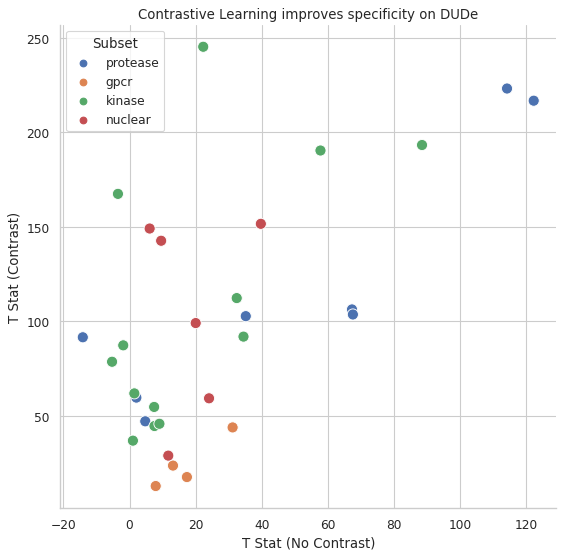

In [196]:
plt.figure(figsize=(8, 8), dpi=80)
sns.set(style="whitegrid", font_scale=1)

sns.scatterplot(data=arp_small,
                x="No Contrast",
                y="Contrast",
                hue="Subset",
                s=100,
               )
# plt.plot([0,1],[0,1],linestyle="--",color="grey")
plt.xlabel("T Stat (No Contrast)")
plt.ylabel("T Stat (Contrast)")
# plt.xscale("log")
# plt.yscale("log")
plt.title("Contrastive Learning improves specificity on DUDe")
sns.despine()
# plt.savefig("../img/dude_pval_scatterplot.png",bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
sns.set(style="whitegrid", font_scale=1)

sns.scatterplot(data=arp_small,
                x="No Contrast",
                y="Contrast",
                hue="Subset",
                s=100,
               )
plt.plot([0,1],[0,1],linestyle="--",color="grey")
plt.xlabel("PValue (No Contrast)")
plt.ylabel("PValue (Contrast)")
# plt.xscale("log")
# plt.yscale("log")
plt.title("Contrastive Learning improves specificity on DUDe")
plt.show()

# Margin Ablation Study

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
subset_list = pd.read_csv(f'{BASE_DIR}/dataset/DUDe/dude_subset_list.txt',header=None)
splitdf = pd.read_csv('../dataset/DUDe/dude_within_type_train_test_split.csv',header=None)

In [68]:
# def cohen_d(x0,x1):
#     u0 = np.mean(x0)
#     u1 = np.mean(x1)
#     s = np.std(np.concatenate([x0,x1]))
#     return (u1 - u0) / s

def cohen_d(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u2 - u1) / s

def distance_from_line(x0,y0):
    x1,y1 = (-1,-1)
    x2,y2 = (10,10)
    
    d = np.abs((x2-x1)*(y1-y0) - (x1 - x0)*(y2 - y1)) / np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return d

In [59]:
test_targets = splitdf[splitdf[1] == 'test'][0].values
target_key = subset_list[subset_list[0].isin(test_targets)]
target_key.head()

,0,1
1,ada17,protease
3,casp3,protease
5,fa10,protease
8,lkha4,protease
10,reni,protease


In [14]:
test_targets

array(['adrb2', 'reni', 'urok', 'ada17', 'lkha4', 'thrb', 'fa10', 'casp3',
       'try1', 'rxra', 'esr1', 'pparg', 'prgr', 'ppara', 'gcr', 'akt2',
       'csf1r', 'mk14', 'wee1', 'vgfr2', 'mp2k1', 'src', 'mk10', 'met',
       'lck', 'rock1', 'braf', 'kpcb', 'adrb1', 'cxcr4', 'drd3'],
      dtype=object)

In [155]:
models = ['no_decay_margin0', 'tanh_decay_restart', 'cosine_anneal_restart']
model_names_clean = sorted(['No Decay (0 Margin)', 'Tanh Decay with Restart', 'Cosine Annealing with Restart'])

score_dict = {}
effect_sizes = []

for t in test_targets:
    for m in models:
        scores = pd.read_csv(f'../results/marginAblation/{m}/DUDe_{t}_{m}_best_model_scores.csv',index_col=0)
        score_dict[(m,t)] = scores
        actives = scores[scores['label'] == 'Active'].scores
        decoys = scores[scores['label'] == 'Decoy'].scores
        effect_sizes.append((t, m, cohen_d(decoys, actives)))
effect_sizes = pd.DataFrame(effect_sizes,columns=['Target','Margin','Effect Size'])
effect_sizes_piv = effect_sizes.pivot('Target','Margin')
effect_sizes_piv.columns = model_names_clean
effect_sizes_piv.index = effect_sizes_piv.index.str.upper()
effect_sizes_piv

,Cosine Annealing with Restart,No Decay (0 Margin),Tanh Decay with Restart
Target,,,
ADA17,1.524468,1.110936,3.387772
ADRB1,1.840664,1.290660,2.021645
ADRB2,1.880310,1.293789,1.963342
AKT2,9.736412,2.525682,6.384842
BRAF,9.395813,3.937993,9.408692
CASP3,0.346235,0.248625,0.825929
CSF1R,7.629392,3.767889,7.652105
CXCR4,1.016294,0.791677,1.306398
DRD3,2.014214,0.862989,1.821789


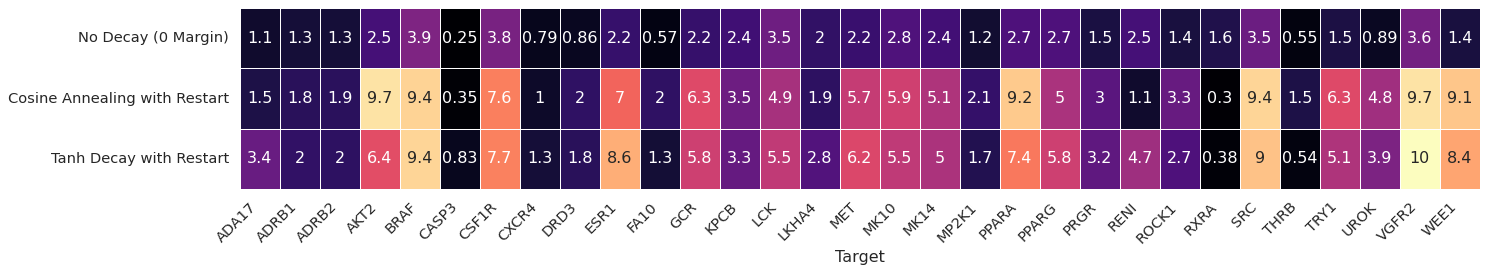

In [157]:
plt.figure(figsize=(20, 3), dpi=80)
sns.set(style="whitegrid", font_scale=1.2)

sns.heatmap(effect_sizes_piv.T.loc[['No Decay (0 Margin)', "Cosine Annealing with Restart", "Tanh Decay with Restart"],:],
            annot=True, xticklabels=True, linewidths=0.5, cmap='magma',cbar=False
           )
plt.xticks(rotation=45,ha='right')
plt.savefig('../img/marginAblation/three_model_heatmap.svg',bbox_inches='tight')
plt.show()

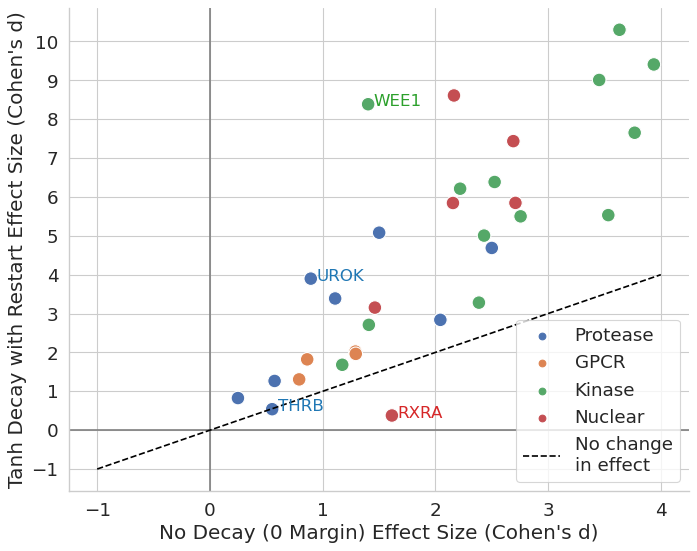

In [158]:
plt.figure(figsize=(10, 8), dpi=80)
sns.set(style="whitegrid", font_scale=1.5)

m0,m1 = 1,2

target_type_hue = target_key.sort_values(by=0)[1].map({
    'protease': f'Protease',
    'gpcr': f'GPCR',
    'kinase': f'Kinase',
    'nuclear': f'Nuclear'
}).values

pal_map = {
    f'Protease': sns.color_palette('tab10')[0],
    f'GPCR': sns.color_palette('tab10')[1],
    f'Kinase': sns.color_palette('tab10')[2],
    f'Nuclear': sns.color_palette('tab10')[3]
}

sns.scatterplot(
    data=effect_sizes_piv,
    x=model_names_clean[m0],
    y=model_names_clean[m1],
    hue = target_type_hue,
    s = 150
)

residuals = {}
for i, r in effect_sizes_piv.reset_index().iterrows():
    xef = r[model_names_clean[m0]]
    yef = r[model_names_clean[m1]]
    # if (xef > 2) or (yef > 6) or (yef-xef < 0):
    residuals[r['Target']] = distance_from_line(xef, yef)
    if (yef / xef > 4) or (yef/xef < 1):
        plt.annotate(r['Target'].upper(),
                     (xef+0.05, yef-0.05),
                     color = pal_map[target_type_hue[i]],
                     fontsize='small',
                     # backgroundcolor='white'
                    )

plt.xlabel(f"{model_names_clean[m0]} Effect Size (Cohen's d)")
plt.ylabel(f"{model_names_clean[m1]} Effect Size (Cohen's d)")
plt.xticks(np.arange(-1,12,1))
plt.yticks(np.arange(-1,12,1))
plt.axvline(0,linestyle="-",color="grey")
plt.axhline(0,linestyle="-",color="grey")
plt.plot([-1,4],[-1,4],linestyle="--",color="black",label='No change\nin effect')
plt.legend(loc='lower right')
sns.despine()
plt.savefig('../img/marginAblation/nodecay_v_tanh_restart.svg',bbox_inches='tight')
plt.show()

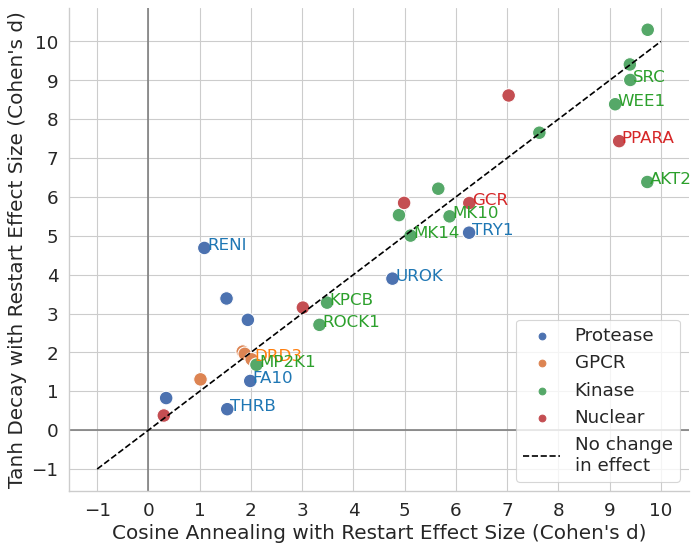

In [159]:
plt.figure(figsize=(10, 8), dpi=80)
sns.set(style="whitegrid", font_scale=1.5)

m0,m1 = 0,2

target_type_hue = target_key.sort_values(by=0)[1].map({
    'protease': f'Protease',
    'gpcr': f'GPCR',
    'kinase': f'Kinase',
    'nuclear': f'Nuclear'
}).values

pal_map = {
    f'Protease': sns.color_palette('tab10')[0],
    f'GPCR': sns.color_palette('tab10')[1],
    f'Kinase': sns.color_palette('tab10')[2],
    f'Nuclear': sns.color_palette('tab10')[3]
}

sns.scatterplot(
    data=effect_sizes_piv,
    x=model_names_clean[m0],
    y=model_names_clean[m1],
    hue = target_type_hue,
    s = 150
)

residuals = {}
for i, r in effect_sizes_piv.reset_index().iterrows():
    xef = r[model_names_clean[m0]]
    yef = r[model_names_clean[m1]]
    # if (xef > 2) or (yef > 6) or (yef-xef < 0):
    residuals[r['Target']] = distance_from_line(xef, yef)
    if (yef / xef > 4) or (yef/xef < 1):
        plt.annotate(r['Target'].upper(),
                     (xef+0.05, yef-0.05),
                     color = pal_map[target_type_hue[i]],
                     fontsize='small',
                     # backgroundcolor='white'
                    )

plt.xlabel(f"{model_names_clean[m0]} Effect Size (Cohen's d)")
plt.ylabel(f"{model_names_clean[m1]} Effect Size (Cohen's d)")
plt.xticks(np.arange(-1,12,1))
plt.yticks(np.arange(-1,12,1))
plt.axvline(0,linestyle="-",color="grey")
plt.axhline(0,linestyle="-",color="grey")
plt.plot([-1,10],[-1,10],linestyle="--",color="black",label='No change\nin effect')
plt.legend(loc='lower right')
sns.despine()
plt.savefig('../img/marginAblation/cosine_restart_v_tanh_restart.svg',bbox_inches='tight')
plt.show()